In [1]:
import arviz as az
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme('paper', 'white', font='helvetica', font_scale=1.25, palette='tab10')
import os.path as op
from risk_experiment.cogmodels.fit_model import build_model, get_data
bids_folder = '/data/ds-risk'

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [14]:
def load_data(session):
    model_label = 'neural3'
    bids_folder = '/data/ds-risk'
    roi = 'npcr'

    df = get_data(model_label, session, bids_folder, roi)
    model = build_model(model_label, df, roi)
    if session is None:
        idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-neural33_trace.netcdf'))
    else:
        idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'ses-{session}_model-neural3_trace.netcdf'))

    return df, model, idata


def get_pars(session):

    df, model, idata = load_data(session)
    mean_risky_prior_shift = idata['posterior']['risky_prior_std'].to_dataframe().xs('sd', 0, -1).groupby('subject').mean()
    mean_safe_prior_shift = idata['posterior']['safe_prior_std'].to_dataframe().xs('sd', 0, -1).groupby('subject').mean()
    n1_evidence_sd = idata['posterior']['n1_evidence_sd'].to_dataframe().xs('sd', 0, -1).groupby('subject').mean()

    pars = mean_safe_prior_shift.join(mean_risky_prior_shift).join(n1_evidence_sd)

    df['EV1'] = df['prob1']*df['n1']
    df['EV2'] = df['prob2']*df['n2']

    df.loc[df.choice == 1.0, 'EV(choice)'] = df['EV1']
    df.loc[df.choice == 2.0, 'EV(choice)'] = df['EV2']
    tmp = df.groupby(['subject', 'median_split(sd)']).mean()[['EV(choice)']]

    loss = tmp.unstack('median_split(sd)').droplevel(0, axis=1)
    loss = loss['Low neural uncertainty'] - loss['High neural uncertainty']
    pars['mean_prior_shift'] = pars[['risky_prior_std', 'safe_prior_std']].mean(1)
    pars['loss'] = loss
    

    return pars

In [20]:
sessions = ['3t2', '7t2', None]

pars = []

for session in sessions:
    pars.append(get_pars(session))

sessions = ['3t2', '7t2', 'both']

pars = pd.concat(pars, keys=sessions, names=['session'])

100%|██████████| 30/30 [00:01<00:00, 28.84it/s]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_70946/1008591576.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject', 'median_split(sd)']).mean()[['EV(choice)']]
100%|██████████| 30/30 [00:00<00:00, 32.39it/s]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_70946/1008591576.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = df.groupby(['subject', 'median_split(sd)']).mean()[['EV(choice)']]
100%|██████████| 30/30 [00:01<00:00, 23.54it/s]
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_70946/1

In [22]:
for session, p in pars.groupby('session'):
    print(p.corr().loc['loss'])

safe_prior_std      0.158939
risky_prior_std     0.064477
n1_evidence_sd      0.026310
mean_prior_shift    0.217644
loss                1.000000
Name: loss, dtype: float64
safe_prior_std      0.008790
risky_prior_std     0.112403
n1_evidence_sd     -0.254255
mean_prior_shift    0.110698
loss                1.000000
Name: loss, dtype: float64
safe_prior_std      0.130259
risky_prior_std     0.062436
n1_evidence_sd     -0.128839
mean_prior_shift    0.147990
loss                1.000000
Name: loss, dtype: float64


In [31]:
import seaborn as sns
import numpy as np

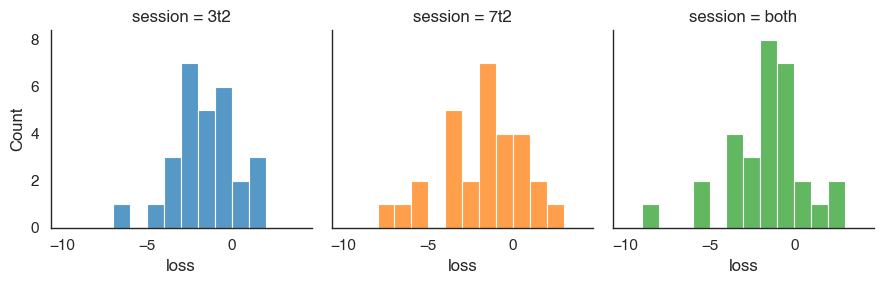

In [33]:
fac = sns.FacetGrid(pars.reset_index(), hue='session', col='session')
fac.map(sns.histplot, 'loss', fill=True, bins=np.arange(-10, 5))